In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import pygazeanalyser
import matplotlib
from matplotlib import pyplot as plt
from pygazeanalyser.edfreader import read_edf
from scipy import stats, signal, ndimage
import re
import os
import mne
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
# set relevant directories and paths
#workingfolder = '/Users/user/Desktop/Experiments/Nick/AttentionSaccade/' #laptop directory
workingfolder = '/home/sammirc/Experiments/Nick/AttentionSaccade' #workstation directory
eyedat        = os.path.join(workingfolder, 'eyes')
behdat        = os.path.join(workingfolder, 'behaviour/csv')
eegdat        = os.path.join(workingfolder, 'EEG') #only on workstation though, no eeg data on laptop
eyelist       = os.listdir(eyedat)
eyelist       = np.sort(eyelist)
behlist       = np.sort(os.listdir(behdat))
saccadedat    = os.path.join(workingfolder, 'saccades')
if not os.path.exists(saccadedat):
    os.mkdir(saccadedat)
sublist = [4, 5, 6, 7, 8, 9]
parts   = ['a','b']
#1KHz  sample: 1 5 6 7 8 9
#250Hz sample: 4

In [3]:
# specs for the task
resxy = (1920,1080)
scrsize = (60,34)
scrdist = 100 # cm
#pixpcm = np.mean([resxy[0]/scrsize[0],resxy[1]/scrsize[1]])
#samplerate = 1000.0 # Hz , sample every 1ms. subject 4 has 250Hz SR, all other 1kHz
samplerate = 250.0 #for subject 4
# Data files
sep = '\t' #value separator
EDFSTART = "_BEG"
EDFSTOP  = "END"
TRIALORDER = ["B(.*)_T(.*)_BEG","B(.*)_T(.*)_CUE","B(.*)_T(.*)_ARR","B(.*)_T(.*)_RESP","B(.*)_T(.*)_END"]
INVALCODE = np.NaN

In [ ]:
# columns in the behavioural data
# subject  - subject number
# session  - session number
# task     - task type (1 = attention, 2 = saccade)
# cuecol   - 
# cueloc   - cued location (1:8)
# validity - validity of cue (1 = valid, 0 = invalid)
# targloc  - location of target (1:8) - can be same or different to cueloc depending on validity of trial
# targtilt - orientation of target (1 = , 2 = )
# delay    -
# resp     - response made: 0 = no response, 1 = , 2 = 
# time     - NaN on saccade trials (or trials with no response), otherwise RT in seconds
# corr     - accuracy of trial (1 = correct, 0 = incorrect), all saccade trials coded with 0 as no response

In [5]:
sub = 0
fname    = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[0]))
datname  = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[0]))
bdata    = pd.DataFrame.from_csv(datname, header=0, sep = ',', index_col=False)
edata    = read_edf(fname, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)

fname2   = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[1]))
datname2 = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[1]))
bdata2   = pd.DataFrame.from_csv(datname2, header=0, sep = ',', index_col=False)
edata2   = read_edf(fname2, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)

In [8]:
edat = []
for sub in range(len(sublist)):
    print('working on S%02d'%(sublist[sub]))
    fname    = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[0]))
    datname  = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[0]))
    bdata    = pd.DataFrame.from_csv(datname, header=0, sep = ',', index_col=False)
    edata    = read_edf(fname, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)

    fname2   = os.path.join(eyedat, 'AttSacc_S%02d%s.asc'%(sublist[sub], parts[1]))
    datname2 = os.path.join(behdat, 'AttSacc_S%02d%s.csv'%(sublist[sub], parts[1]))
    bdata2   = pd.DataFrame.from_csv(datname2, header=0, sep = ',', index_col=False)
    edata2   = read_edf(fname2, EDFSTART, EDFSTOP, missing = np.NaN, debug = False)

    print('combining S%02d part 1 eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
    for trial in range(len(edata)):
        trl  = bdata.iloc[trial,:]
        edata[trial]['behaviour'] = {
            'subject'  : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
            'task'     : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
            'cueloc'   : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
            'targloc'  : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
            'delay'    : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
            'time'     : trl.loc['time']    , 'corr'     : trl.loc['corr']     }
        trigs = edata[trial]['events']['msg']
        if len(trigs) == 4: # attention trial
            trltype = 1 #attention trial
            begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
            cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
            arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            resptrig  = edata[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
        elif len(trigs) == 3: #saccade trial, no response
            trltype = 2 #saccade trial
            begtrig   = edata[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
            cuetrig   = edata[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
            arrtrig   = edata[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
        #find sample nearest to the trigger time
        begind  = np.argmin(np.abs(begtrig  - edata[trial]['trackertime']))
        cueind  = np.argmin(np.abs(cuetrig  - edata[trial]['trackertime']))
        arrind  = np.argmin(np.abs(arrtrig  - edata[trial]['trackertime']))
        if trltype == 1:
            respind = np.argmin(np.abs(resptrig - edata[trial]['trackertime']))
        if trltype == 1: #attention trial triggers
            triggers = { #make dictionary of triggers
                "start" : [begtrig,  begind],
                "cue"   : [cuetrig,  cueind],
                "array" : [arrtrig,  arrind],
                "resp"  : [resptrig, respind]}
        if trltype == 2: #saccade trial triggers
            triggers = { #make dictionary of triggers
                "start" : [begtrig,  begind],
                "cue"   : [cuetrig,  cueind],
                "array" : [arrtrig,  arrind],}
        edata[trial]['triggers'] = triggers
        # triggers : [EDFTIME, TRIAL_TIME]     
    print('writing saccade data to file now')
    saccfname = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[0])
    saccfile     = open(saccfname, 'w')
    saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
        'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
    for trial in range(len(edata)):
        saccades = edata[trial]['events']['Esac']
        tnum = trial + 1
        subject = edata[trial]['behaviour']['subject']
        ttime = edata[trial]['trackertime'][0]
        #saccades[saccade]: start, end, duration, startx, starty, endx, endy
        for saccade in range(len(saccades)):
            saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                 (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
            saccfile.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                    subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                    saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                    saccades[saccade][5],saccades[saccade][6],saccadevel))
    saccfile.close()
    print('combining S%02d part 2 eyetracking and behavioural data, and adding triggers to eyetracking data'%(sublist[sub]))
    for trial in range(len(edata2)):
        trl          = bdata2.iloc[trial,:]
        edata2[trial]['behaviour'] = {
            'subject'  : trl.loc['subject'] , 'session'  : trl.loc['session'] ,
            'task'     : trl.loc['task']    , 'cuecol'   : trl.loc['cuecol']  ,
            'cueloc'   : trl.loc['cueloc']  , 'validity' : trl.loc['validity'],
            'targloc'  : trl.loc['targloc'] , 'targtilt' : trl.loc['targtilt'],
            'delay'    : trl.loc['delay']   , 'resp'     : trl.loc['resp']    ,
            'time'     : trl.loc['time']    , 'corr'     : trl.loc['corr']     }
        trigs = edata2[trial]['events']['msg']
        if len(trigs) == 4: # attention trial
            trltype = 1 #attention trial
            begtrig   = edata2[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
            cuetrig   = edata2[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
            arrtrig   = edata2[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
            resptrig  = edata2[trial]['events']['msg'][3][0] #get edf timestamp for array trigger
        elif len(trigs) == 3: #saccade trial, no response
            trltype = 2 #saccade trial
            begtrig   = edata2[trial]['events']['msg'][0][0] #get edf timestamp for the trial start trigger
            cuetrig   = edata2[trial]['events']['msg'][1][0] #get edf timestamp for cue trigger
            arrtrig   = edata2[trial]['events']['msg'][2][0] #get edf timestamp for array trigger
        #find sample nearest to the trigger time
        begind  = np.argmin(np.abs(begtrig  - edata2[trial]['trackertime']))
        cueind  = np.argmin(np.abs(cuetrig  - edata2[trial]['trackertime']))
        arrind  = np.argmin(np.abs(arrtrig  - edata2[trial]['trackertime']))
        if trltype == 1:
            respind = np.argmin(np.abs(resptrig - edata2[trial]['trackertime']))
        if trltype == 1: #attention trial triggers
            triggers = { #make dictionary of triggers
                "start" : [begtrig,  begind],
                "cue"   : [cuetrig,  cueind],
                "array" : [arrtrig,  arrind],
                "resp"  : [resptrig, respind]}
        if trltype == 2: #saccade trial triggers
            triggers = { #make dictionary of triggers
                "start" : [begtrig,  begind],
                "cue"   : [cuetrig,  cueind],
                "array" : [arrtrig,  arrind],}
        edata2[trial]['triggers'] = triggers
        # triggers : [EDFTIME, TRIAL_TIME]     
    print('writing saccade data to file now')
    saccfname2    = '%s/AttentionSaccade_S%02d%s_SaccadeData.csv' %(saccadedat, sublist[sub],parts[1])
    saccfile2     = open(saccfname2, 'w')
    saccfile2.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
        'subject','trial','start','end','duration','startx', 'starty','endx', 'endy', 'velocity'))
    for trial in range(len(edata2)):
        saccades = edata2[trial]['events']['Esac']
        tnum = trial + 1
        subject = edata2[trial]['behaviour']['subject']
        ttime = edata2[trial]['trackertime'][0]
        #saccades[saccade]: start, end, duration, startx, starty, endx, endy
        for saccade in range(len(saccades)):
            saccadevel = np.sqrt((saccades[saccade][5]-saccades[saccade][3])**2 +
                                 (saccades[saccade][6]-saccades[saccade][4])**2  ) / saccades[saccade][2]
            saccfile2.write('{},{},{},{},{},{},{},{},{},{} \n'.format(
                    subject,tnum,saccades[saccade][0]-ttime,saccades[saccade][1]-ttime,
                    saccades[saccade][2],saccades[saccade][3],saccades[saccade][4],
                    saccades[saccade][5],saccades[saccade][6],saccadevel))
    saccfile2.close()
    comb = edata + edata2
    edat.append(comb)

working on S04
combining S04 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
combining S04 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S05
combining S05 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
combining S05 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S06
combining S06 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
combining S06 part 2 eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
working on S07
combining S07 part 1 eyetracking and behavioural data, and adding triggers to eyetracking data
writing saccade data to file now
combining S07 part 2 eyetracking and behavio

In [22]:
edat[0][0].keys()

['triggers', 'behaviour', 'trackertime', 'time', 'y', 'x', 'events', 'size']

In [28]:
subject = edat[1] # read in subject 5 as it's first participant at 1Khz sample rate

In [56]:
subject[1]['behaviour']['task']

2.0

In [65]:
len(subject)
subject[0].keys()
sacctask = [x for x in range(len(subject)) if subject[x]['behaviour']['task']==2.0]
subject_sacctask = [subject[x] for x in sacctask]
len(subject_sacctask)


960

In [120]:
temp = subject_sacctask[0]
print temp.keys()
print('\n')

trigs = temp['triggers']
print trigs
print('\n')

targtrig = trigs['array']
print targtrig
print('\n')

print temp['events']['Esac']
print('\n')

ttime = temp['trackertime'][0]
targsac = [x for x in range(len(temp['events']['Esac'])) if temp['events']['Esac'][x][0] >=  targtrig[0]]


print targsac
print('\n')

#np.squeeze(temp['events']['Esac'][:][0]-ttime)
trlsaccades = np.array(temp['events']['Esac'][:])
trlsaccades = np.sort(trlsaccades,0)
print trlsaccades[:,0]
print('\n')

inds = np.squeeze(np.where(trlsaccades[:,0] >= targtrig[0])) 
print np.squeeze(np.where(trlsaccades[:,0] >= targtrig[0]))
print('\n')

print trlsaccades[inds[0]][0] -ttime
print('\n')

print (trlsaccades[inds[0]][0] -ttime) - targtrig[1]
# ^^ time in ms taken to make first saccade after the target appeared on screen

['triggers', 'behaviour', 'trackertime', 'time', 'y', 'x', 'events', 'size']


{'start': [4417344, 0], 'cue': [4417845, 501], 'array': [4419385, 2041]}


[4419385, 2041]


[[4418446, 4418452, 7, 1002.6, 604.9, 989.6, 596.2], [4419619, 4419660, 42, 993.0, 604.3, 1410.5, 784.7], [4419617, 4419673, 57, 963.2, 598.0, 1366.6, 767.9], [4419987, 4420031, 45, 1387.3, 772.7, 987.1, 576.9], [4419986, 4420034, 49, 1379.2, 761.1, 978.8, 567.7]]


[1, 2, 3, 4]


[ 4418446.  4419617.  4419619.  4419986.  4419987.]


[1 2 3 4]


2273.0


232.0


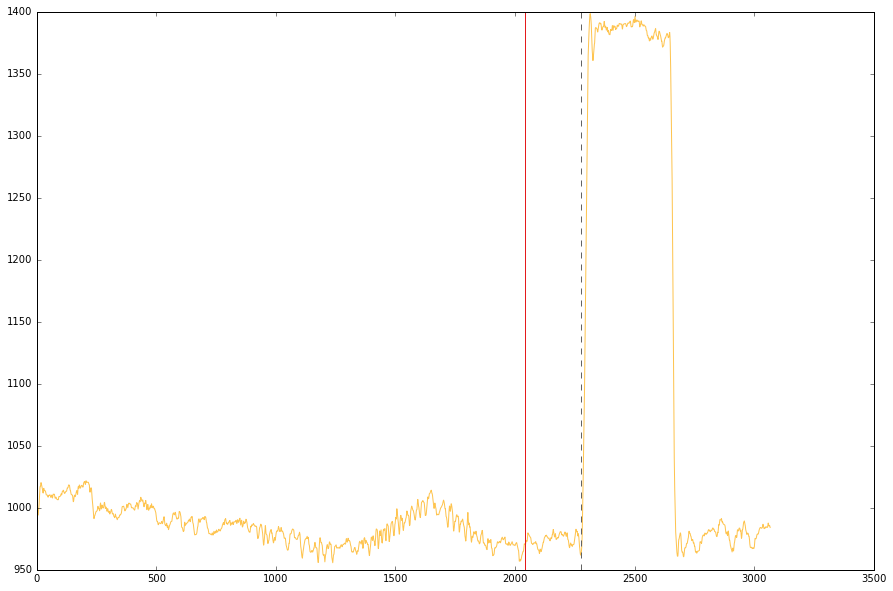

In [93]:
plt.figure(figsize = (15,10))
plt.plot(temp['x'], color = '#fec44f')
plt.axvline(targtrig[1], color = '#e41a1c')
plt.axvline(temp['events']['Esac'][1][0]-ttime, ls = 'dashed', color = '#636363')
#plt.axvline(temp['events']['Esac'][2][0]-ttime, ls = 'dashed', color = '#636363')
#plt.axvline(temp['events']['Esac'][3][0]-ttime, ls = 'dashed', color = '#636363')
#plt.axvline(temp['events']['Esac'][4][0]-ttime, ls = 'dashed', color = '#636363')


In [27]:
# edat contains all, both eyetracking and behavioural, but it's computationally 'intensive' to create this
# every time you want to access this data. This structure should be created once only, then output as a
# text file that can be read in, rather than recreating and overwriting certain things each time
# this section will separate edat by subject - edat[0] contains subject 4 data at the moment and then write

# need to find a dataformat that can make each subject data to a file
#that can be read in the subsequent cell replacing the need for some cells above